<a href="https://colab.research.google.com/github/gustavmaskowitz/jupyter-notebooks/blob/master/image_denoising_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model analysis
This notebook will help you to analyze the output from a deployed autoencoder model.

In [0]:
!pip list

---
**NOTE!** 

For more detailed information about installing sidekick, see https://github.com/Peltarion/sidekick

---


In [2]:
!pip install git+https://github.com/Peltarion/sidekick#egg=sidekick

  Cloning https://github.com/Peltarion/sidekick to /tmp/pip-install-qd79irly/sidekick
  Running command git clone -q https://github.com/Peltarion/sidekick /tmp/pip-install-qd79irly/sidekick
  Stored in directory: /tmp/pip-ephem-wheel-cache-tzaphuhj/wheels/b3/e4/bc/55cf1064c227ab7ff58d705ed4e6d11b0fbaddf04832692dad
Successfully built sidekick


In [0]:
import glob
import random
import sidekick
import numpy as np
import os
import seaborn as sns
from PIL import Image

## Setup

In [0]:
client = sidekick.Deployment(
    url='https://a.peltarion.com/deployment/7b49d575-c028-400d-808f-2e3c42e54a0d/forward',
    token='ad9606c6-a9d9-427b-8208-635d39d80f8a',
    dtypes_in={'image': 'Image (28x28x1)'},
    dtypes_out={'image': 'Image (28x28x1)'}
)

The test dataset (unlabeled) is available here:
https://storage.googleapis.com/bucket-8732/MNISTtest.zip

In [6]:
!curl -O https://storage.googleapis.com/bucket-8732/MNISTtest.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4360k  100 4360k    0     0  11.0M      0 --:--:-- --:--:-- --:--:-- 11.0M


In [7]:
!unzip MNISTtest.zip

Archive:  MNISTtest.zip
   creating: MNISTtest/
  inflating: MNISTtest/digit-1967.png  
  inflating: MNISTtest/digit-8943.png  
  inflating: MNISTtest/digit-9485.png  
  inflating: MNISTtest/digit-3816.png  
  inflating: MNISTtest/digit-3802.png  
  inflating: MNISTtest/digit-8957.png  
  inflating: MNISTtest/digit-9491.png  
  inflating: MNISTtest/digit-1973.png  
  inflating: MNISTtest/digit-1783.png  
  inflating: MNISTtest/digit-3194.png  
  inflating: MNISTtest/digit-4823.png  
  inflating: MNISTtest/digit-5283.png  
  inflating: MNISTtest/digit-7494.png  
  inflating: MNISTtest/digit-6952.png  
  inflating: MNISTtest/digit-287.png  
  inflating: MNISTtest/digit-7480.png  
  inflating: MNISTtest/digit-6946.png  
  inflating: MNISTtest/digit-293.png  
  inflating: MNISTtest/digit-5297.png  
  inflating: MNISTtest/digit-4189.png  
  inflating: MNISTtest/digit-3180.png  
  inflating: MNISTtest/digit-4837.png  
  inflating: MNISTtest/digit-16.png  
  inflating: MNISTtest/digit-1797.pn

In [0]:
data_dir = 'MNISTtest'

In [9]:
test_images = []
for filename in glob.glob(os.path.join(data_dir,'*.png')):    
    im=Image.open(filename)
    im2 = im.copy()
    test_images.append(im2)
    im.close()
print('Number of images: {}'.format(len(test_images)))

Number of images: 10000


## Reconstruct test images with added noise

In [0]:
def add_noise(im):
    np_im = np.array(im)
    row, col = np_im.shape
    gauss = np.random.randn(row,col)
    gauss = gauss.reshape(row, col)        
    noisy = np_im + np_im * gauss
    noisy_im = Image.fromarray(noisy)
    noisy_im = noisy_im.convert("L")
    noisy_im.format = 'PNG'
    return noisy_im

In [0]:
test_images_i = iter(test_images)

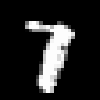

'Original'

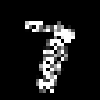

'Noisy'

In [12]:
img = next(test_images_i)
display(img.resize((100,100)),'Original')
img = add_noise(img)
display(img.resize((100,100)),'Noisy')

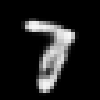

'Denoised'

In [13]:
recon_img = client.predict(image=img)['image']
display(recon_img.resize((100,100)),'Denoised')

In [0]:
!unzip ManualNoisyImages.zip

In [0]:
spotted_pic = Image.open('ManualNoisyImages/digit-69.png')

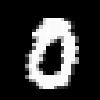

'Orig'

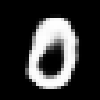

'Denoised'

In [44]:
display(spotted_pic.resize((100,100)),'Orig')
clean_me = client.predict(image=spotted_pic)['image']
display(clean_me.resize((100,100)),'Denoised')

## Calculate and plot distribution of reconstruction errors

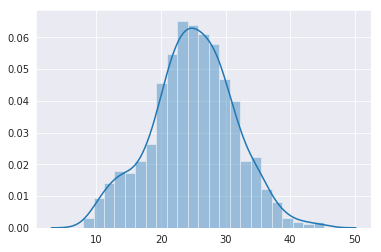

In [14]:
# 1,000 samples
random_samples = random.sample(test_images, k=1000)
errors = []
for img in random_samples:
    img = add_noise(img)    
    recon_img = client.predict(image=img)['image']
    A, B = np.array(img), np.array(recon_img)
    errors.append(np.square(np.subtract(A, B)).mean())
sns.set_style('darkgrid')
sns.distplot(np.array(errors));